In [1]:
import numpy as np
import os
import torch
import sys

from matplotlib import pyplot as plt
from torch import nn
from torchvision.transforms import Normalize,ToTensor, Compose

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from dataset import AnomalyMNIST
from experiments.utils.Supervised import SupervisedModel, train

AnomalyMNIST Dataset (Number of samples: 2400, Number of known anomalies: 200, Number of unknown anomalies: 200)


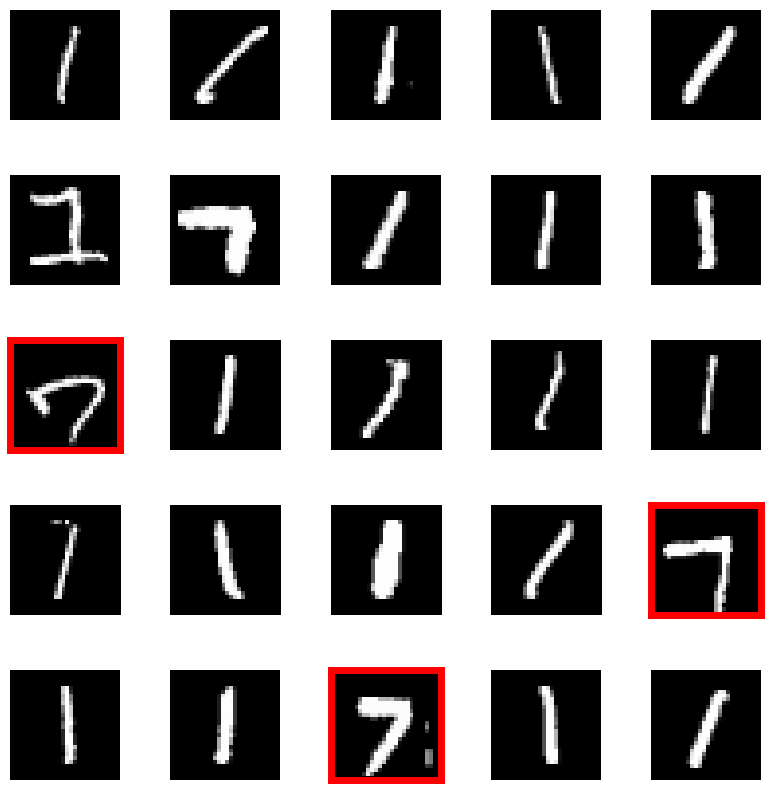

In [2]:
seed = 128
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

dataset = AnomalyMNIST('data/', download=True, transform=transform, n_normal_samples=2000, known_anomalies=0.1, pollution=0.1, seed=seed)
print(dataset)

dataset.montage(5, 5, seed)
plt.show()

In [3]:
model = SupervisedModel((28,28), [1, 16, 24], [1024, 256, 32, 2])
model = train(model, dataset, 128, 50, weighted_sampler=False)

100%|██████████| 50/50 [00:13<00:00,  3.57epoch/s, tls=0.127]


In [5]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

test_dataset_full = MNIST('data/', train = False, download = True, transform = transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx, anomaly_idx])

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)

In [15]:
# model.eval()
model.train()
x_test, y_test = zip(*x_test_set)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test)

y_score = model.score_samples(x_test)
# y_score = model(x_test).detach().numpy()[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:])


0.975125559231389

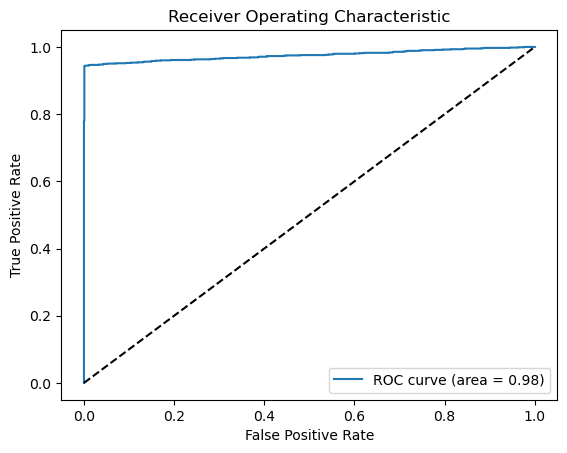

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
_y_score = torch.sigmoid(model.score_samples(x_test).flatten())
fpr, tpr, _ = roc_curve(y_test, y_score[:])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

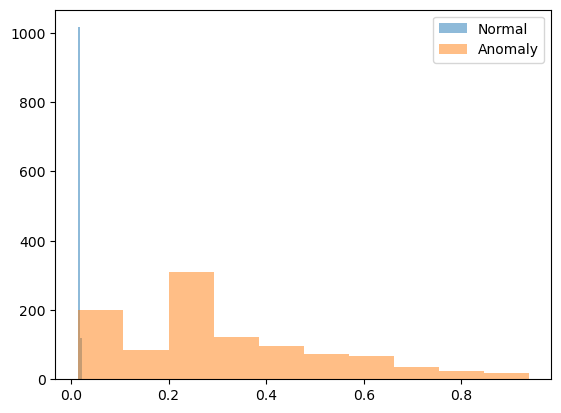

In [17]:
from matplotlib import pyplot as plt
plt.hist(_y_score[y_test==0], bins=10, alpha=0.5, label='Normal')
plt.hist(_y_score[y_test==1], bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

In [18]:
# Classification report
# model.train()
model.eval()
from sklearn.metrics import classification_report
# y_pred = model(x_test).detach().argmax(dim=1)
y_pred = np.where(torch.sigmoid(model(x_test).detach()) > 0.5, 1, 0)
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1135
           1       1.00      0.39      0.56      1028

    accuracy                           0.71      2163
   macro avg       0.82      0.69      0.67      2163
weighted avg       0.81      0.71      0.67      2163



array([[1135,    0],
       [ 632,  396]])

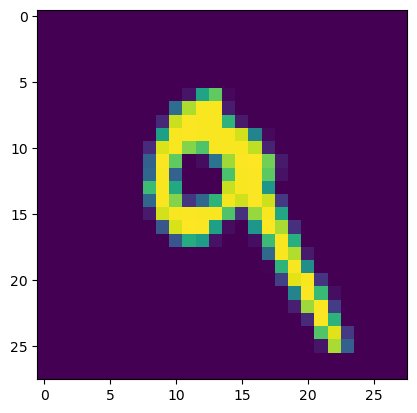

In [19]:
## Extract a 2 from the test dataset
model.eval()
number = 9
test2_dataset = MNIST('data/', train = False, download = True, transform=transform)
test2_idx = torch.where((test2_dataset.targets == number))[0]
test2_dataset = Subset(test2_dataset, test2_idx)

X, y = zip(*test2_dataset)
X = torch.stack(X)
y = torch.tensor(y).flatten()
# y_pred = model(X).detach().argmax(dim=1)
y_score = torch.sigmoid(model(X).detach())
y_pred = np.where(y_score > 0.5, 1, 0)

from matplotlib import pyplot as plt
plt.imshow(X[0,0])


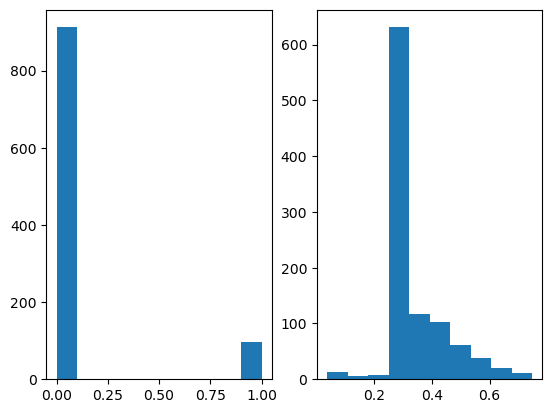

In [12]:
plt.subplot(1,2,1)
plt.hist(y_pred)
plt.subplot(1,2,2)
plt.hist(y_score)
plt.show()

In [13]:
_y = np.ones_like(y)
np.bincount(y_pred == _y)

array([912,  97])

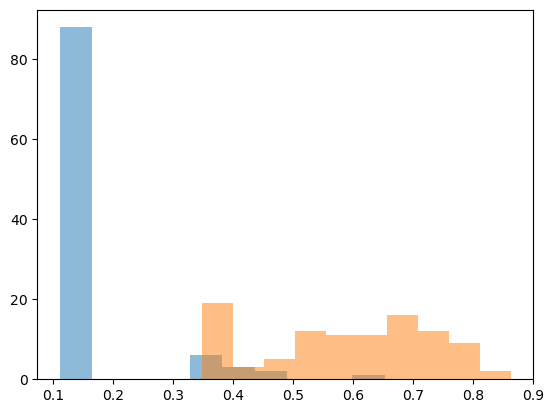

In [14]:
x, y = zip(*[(_x, _y) for _x, _y in dataset])

x = torch.stack(x)
y = torch.tensor(y)

x0 = x[y==0]
x0_idx = torch.randperm(len(x0))[:100]
x0 = x0[x0_idx]
x1 = x[y==1]
x1_idx = torch.randperm(len(x1))[:100]
x1 = x1[x1_idx]

x = torch.cat([x0, x1])
y = torch.cat([torch.zeros(100), torch.ones(100)])

y_score = torch.sigmoid(model.score_samples(x)).flatten()
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

from matplotlib import pyplot as plt
plt.hist(y_score[y==0], bins=10, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=10, alpha=0.5, label='Anomaly')
plt.show()

/tmp/ipykernel_6462/327040539.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.argsort(torch.tensor(_y0_score), descending=True)


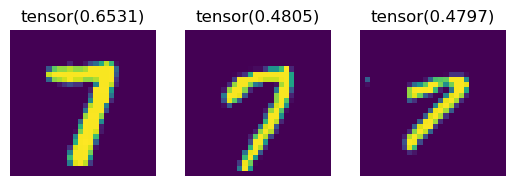

In [15]:
_y0_score = y_score[:100]

# get the idx of the highest 3 sigma
idx = torch.argsort(torch.tensor(_y0_score), descending=True)

plt.subplot(1, 3, 1)
plt.imshow(x0[idx[0]][0])
plt.title(_y0_score[idx[0]])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x0[idx[1]][0])
plt.title(_y0_score[idx[1]])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x0[idx[2]][0])
plt.title(_y0_score[idx[2]])
plt.axis('off')

plt.show()

/tmp/ipykernel_6462/504839126.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.argsort(torch.tensor(_y1_score), descending=False)


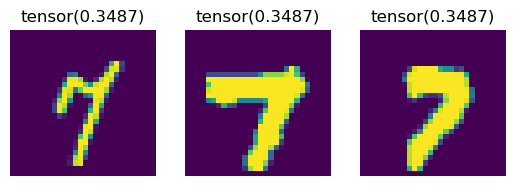

In [16]:
_y1_score = y_score[100:]

# get the idx of the highest 3 _y1_score
idx = torch.argsort(torch.tensor(_y1_score), descending=False)

plt.subplot(1, 3, 1)
plt.imshow(x1[idx[0]][0])
plt.title(_y1_score[idx[0]])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x1[idx[1]][0])
plt.title(_y1_score[idx[1]])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x1[idx[2]][0])
plt.title(_y1_score[idx[2]])
plt.axis('off')

plt.show()

# MedMNIST

In [17]:
import medmnist, torch
from medmnist import INFO, Evaluator
from medmnist.dataset import PneumoniaMNIST
import torch.utils.data as data

import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


Using downloaded and verified file: data/pneumoniamnist.npz
AnomalyPneumoniaMNIST Dataset (Number of samples: 1335, Number of known anomalies: 121, Number of unknown anomalies: 0)


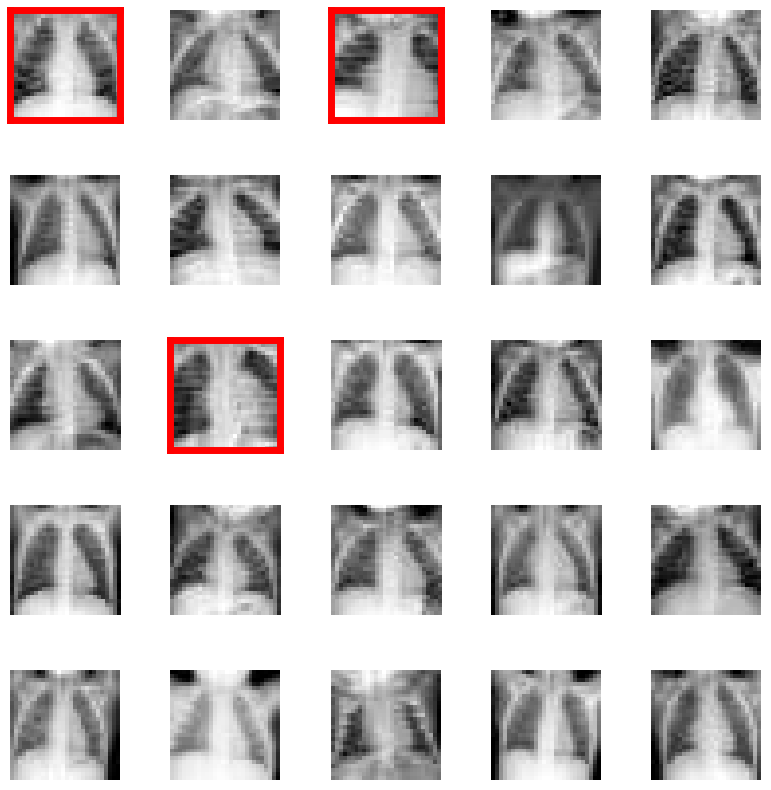

In [18]:
from dataset import AnomalyPneumoniaMNIST
from matplotlib import pyplot as plt
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# Load the dataset
seed = 42
train_dataset = AnomalyPneumoniaMNIST('data/', download=True, transform=data_transform, n_normal_samples=-1, known_anomalies=0.1, pollution=0, seed=seed)
print(train_dataset)

train_dataset.montage(5, 5, seed)
plt.show()

In [19]:
BATCH_SIZE = 128
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True, root='data/')

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=4*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: data/pneumoniamnist.npz


In [21]:
model = SupervisedModel((28,28), [1, 16, 24], [1024, 256, 32, 2])
model = train(model, train_dataset, 128, 100, weighted_sampler=False)

100%|██████████| 100/100 [00:14<00:00,  7.01epoch/s, tls=0.073]


In [22]:
model.eval()
x_test, y_test = zip(*test_dataset)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test).flatten()

# y_score = model(x_test).detach().numpy().mean(axis=1)
y_score = torch.sigmoid(model(x_test)).detach().numpy()
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:])

/tmp/ipykernel_6462/2456852467.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  y_test = torch.tensor(y_test).flatten()


0.9448279640587333

In [23]:
y_score.shape
y_test.shape

torch.Size([624])

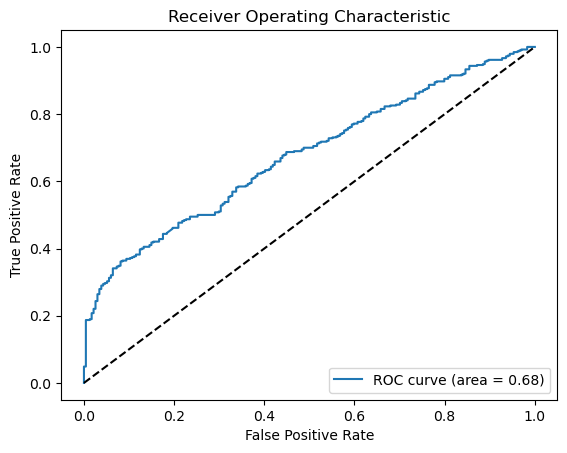

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model.train()
y_score = torch.sigmoid(model.score_samples(x_test).flatten())
fpr, tpr, _ = roc_curve(y_test, y_score[:])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

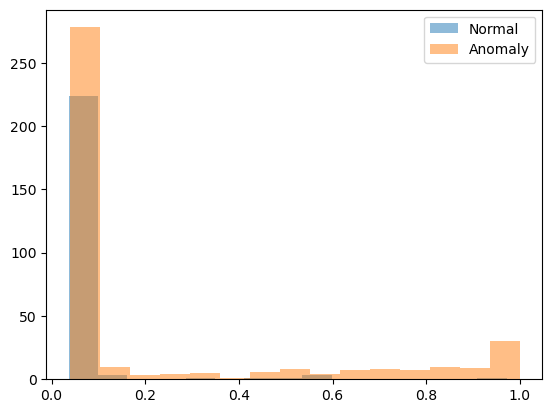

In [34]:
from matplotlib import pyplot as plt
plt.hist(y_score[y_test==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y_test==1], bins=15, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

In [35]:
import numpy as np
from scipy import stats

# Tus datos
data1 = y_score[y_test==0]
data2 = y_score[y_test==1]

# Realizar la prueba t
t_stat, p_value = stats.ttest_ind(data1, data2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


t-statistic: -7.659262663519983
p-value: 7.18974761693726e-14


In [36]:
y_hat = torch.sigmoid(model(x_test))
y_hat = np.where(y_hat > 0.5, 1, 0)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat, target_names=('Normal', 'Anomaly'), zero_division=1))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat)

              precision    recall  f1-score   support

      Normal       0.43      0.98      0.60       234
     Anomaly       0.96      0.23      0.37       390

    accuracy                           0.51       624
   macro avg       0.70      0.61      0.49       624
weighted avg       0.76      0.51      0.46       624



array([[230,   4],
       [300,  90]])

In [37]:
np.bincount(y_test), np.bincount(y_hat)

(array([234, 390]), array([530,  94]))

In [34]:
import os
import sys

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


from experiments.MNIST import ExperimentSupervised

experiment = ExperimentSupervised(0.1, 0.2)

In [35]:
experiment.run()

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:13<00:00,  3.63epoch/s, tls=0.122]


0.9974262500214264

In [36]:
experiment.classification_metrics()

(0.6643550624133149, 1.0, 0.29377431906614787, 0.45413533834586467)

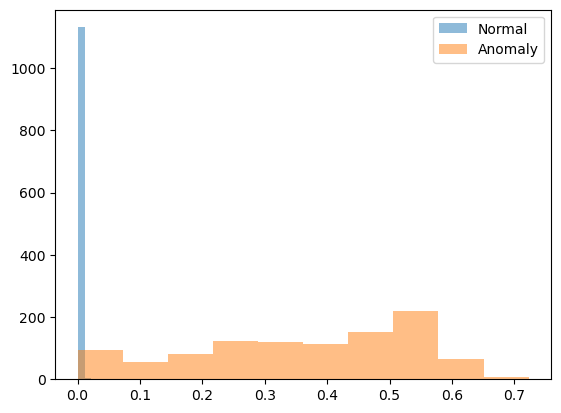

In [38]:
y, scores = experiment.score_samples()

from matplotlib import pyplot as plt
plt.hist(scores[y==0], bins=10, alpha=0.5, label='Normal')
plt.hist(scores[y==1], bins=10, alpha=0.5, label='Anomaly')
plt.legend()
plt.show()

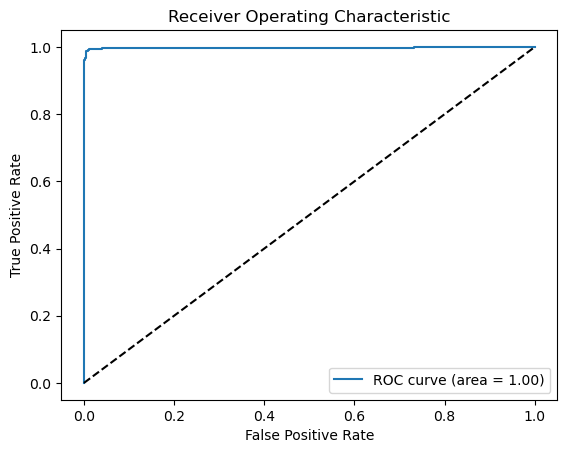

In [39]:
fpr, tpr, roc_auc = experiment.roc_curve()

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()